In [33]:
# K-NEAREST NEIGHBORS
# The model takes as assumption that points that are close to one another are similar
import random
from IPython.display import clear_output
from importnb import Notebook
la = Notebook.load("4 linear_algebra.ipynb")
ml = Notebook.load("11 machine learning.ipynb")
clear_output()
from typing import List, NamedTuple, Dict, Tuple
from collections import Counter, defaultdict
from matplotlib import pyplot as plt

# we need to find a way to classify some new data point, we find the k(5) nearest labele points and let them vote on the new output
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

assert raw_majority_vote(['a', 'b', 'c', 'b', 'b']) == 'b'

# to eliminate the possibility of multiple winners, we can have a lot of options
def majority_vote(labels: List[str]) -> str:
    """Assumes that labels are ordered from nearest to farthest."""
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])

    if num_winners == 1:
        return winner                     # unique winner, so return it
    else:
        return majority_vote(labels[:-1]) # try again without the farthest

# Tie, so look at first 4, then 'b'
assert majority_vote(['a', 'b', 'c', 'b', 'a']) == 'b'

In [34]:
class LabeledPoint(NamedTuple):
    point: la.Vector
    label: str

def knn_classify(k: int,
                 labeled_points: List[LabeledPoint],
                 new_point: la.Vector) -> str:

    # Order the labeled points from nearest to farthest.
    by_distance = sorted(labeled_points,
                         key=lambda lp: la.distance(lp.point, new_point))

    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]

    # and let them vote.
    return majority_vote(k_nearest_labels)

c:\Users\baldif\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


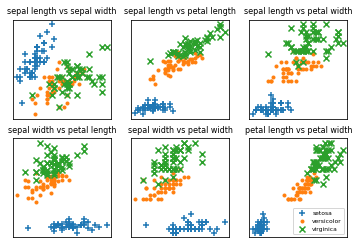

In [35]:
import requests
import csv

data = requests.get(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", verify=False
)

with open('iris.data', 'w') as f:
    f.write(data.text)

def parse_iris_row(row: List[str]) -> LabeledPoint:
    """
    sepal_length, sepal_width, petal_length, petal_width, class
    """
    measurements = [float(value) for value in row[:-1]]
    # class is e.g. "Iris-virginica"; we just want "virginica"
    label = row[-1].split("-")[-1]

    return LabeledPoint(measurements, label)

with open('iris.data') as f:
    reader = csv.reader(f)
    iris_data = [parse_iris_row(row) for row in reader if row]

# We'll also group just the points by species/label so we can plot them
points_by_species: Dict[str, List[la.Vector]] = defaultdict(list)
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

from matplotlib import pyplot as plt
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

In [36]:
random.seed(12)
iris_train, iris_test = ml.split_data(iris_data, 0.70)
assert len(iris_train) == 0.7 * 150
assert len(iris_test) == 0.3 * 150

# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


In [37]:
def random_point(dim: int) -> la.Vector:
    return [random.random() for _ in range(dim)]

def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [la.distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

# in low-dimensional datasets, the closest points tend to be much closer than average
# when you have a lot of dimensions, it’s likely that the closest points aren’t much closer than average
# it's worth to do dimensionality reduction if you have too many dimensions that can corrupt the result
random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum

min_avg_ratio = [min_dist / avg_dist
                 for min_dist, avg_dist in zip(min_distances, avg_distances)]

Curse of Dimensionality: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
